In [184]:
%matplotlib inline

from weavingspace import Tileable
from weavingspace import TileUnit
from weavingspace import WeaveUnit
from weavingspace import tiling_utils

import geopandas as gpd
import shapely.geometry as geom
import topojson

<Axes: >

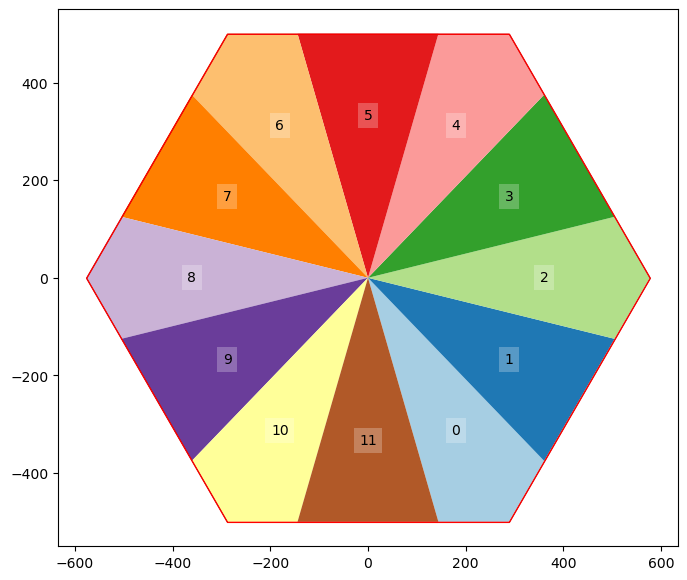

In [213]:
tile = TileUnit(tiling_type = "hex-dissection", n = 12)
tile.plot(show_ids = "id")

<Axes: >

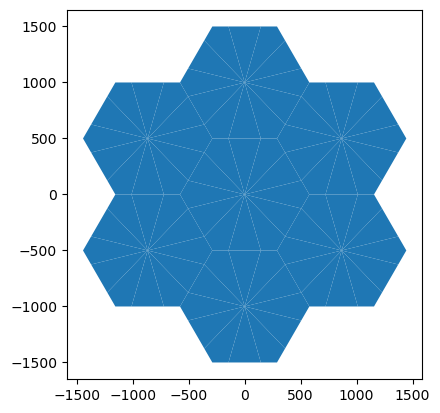

In [214]:
patch = tile.get_local_patch(r = 1, include_0 = True)
patch.plot()

In [215]:
patch_topology = topojson.Topology(patch, prequantize = True).to_dict()

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


## Recover edges from the topology

<Axes: >

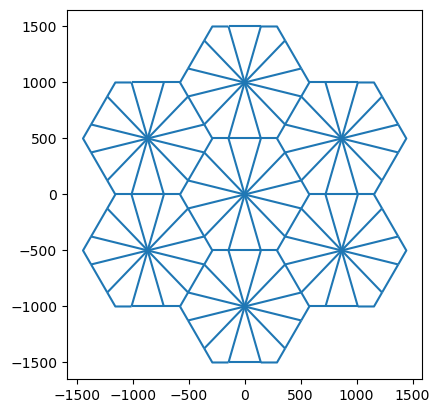

In [216]:
if "transform" in patch_topology:
  sx, sy = patch_topology["transform"]["scale"]
  tx, ty = patch_topology["transform"]["translate"]
  linestrings = []
  for arc in patch_topology["arcs"]:
    pts = [arc[0]]
    for dxdy in arc[1:]:
      pts.append([pts[-1][0] + dxdy[0], pts[-1][1] + dxdy[1]])
    linestrings.append(geom.LineString(pts))
  gs = gpd.GeoSeries(linestrings) \
            .scale(sx, sy, origin = (0, 0)) \
            .translate(tx, ty)
else:
  gs = gpd.GeoSeries([geom.LineString(l) for l in patch_topology["arcs"]])
edges = gpd.GeoDataFrame({"id": range(len(gs))}, geometry = gs, crs = tile.crs)
edges.plot()

## Recover polygons from the topology

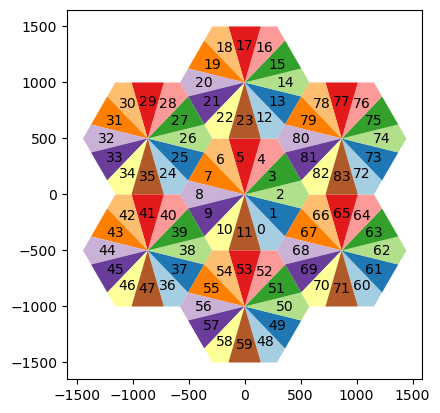

In [218]:
element_ids = []
polygons = []
for obj in patch_topology["objects"]["data"]["geometries"]:
  element_ids.append(obj["properties"]["element_id"])
  pts = []
  for arc in obj["arcs"][0]:
    if arc < 0:
      new_pts = list(reversed(edges.geometry[-arc - 1].coords))
    else:
      new_pts = edges.geometry[arc].coords
    if len(pts) == 0:
      pts.extend(new_pts)
    else:
      pts.extend(new_pts[1:])
  corners = [geom.Point(p) for p in pts]
  polygons.append(geom.Polygon(corners))
faces = gpd.GeoDataFrame(
  {"element_id": element_ids, "id": range(len(element_ids))},
  geometry = polygons, crs = tile.crs
)
ax = faces.plot(column = "element_id", cmap = "Paired")
for polygon, name in zip(faces.geometry, faces.id):
    ax.annotate(xy = (polygon.centroid.x - 80, polygon.centroid.y - 40), text = name)

## Get neighbours from topology

In [219]:
sides = [obj["arcs"][0] 
         for obj in patch_topology["objects"]["data"]["geometries"]]
neighbours = []
for i, sides1 in enumerate(sides):
  for j, sides2 in enumerate(sides[i+1:]):
    for s1 in sides1:
      if -s1 - 1 in sides2:
        neighbours.append((i, j + i + 1))
        continue

n = tile.elements.shape[0]
neighbours = [tuple(sorted([i % n, j % n])) for (i, j) in neighbours]
neighbours = sorted(list(set(neighbours)))
neighbours

[(0, 1),
 (0, 4),
 (0, 8),
 (0, 11),
 (1, 2),
 (1, 7),
 (2, 3),
 (2, 6),
 (2, 10),
 (3, 4),
 (3, 9),
 (4, 5),
 (4, 8),
 (5, 6),
 (5, 11),
 (6, 7),
 (6, 10),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11)]